In [1]:
# from elasticsearch import Elasticsearch
import logging
logging.getLogger('tensorflow').disabled = True
import keras
import os
import re
import json
import urllib
import string
from copy import deepcopy
import pandas as pd
from random import sample, randint, random, seed
from keras import Model
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.layers import CuDNNGRU, Input, \
    Embedding, Dropout, CuDNNLSTM, concatenate, \
    Dense, GRU
from keras.utils import to_categorical, normalize, plot_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score, \
    precision_recall_curve
# import csv

Using TensorFlow backend.


In [0]:
# For reproducibility
seed(77)
np.random.seed(77)

In [0]:
# es = Elasticsearch([{ 'host': 'localhost', 'port': 9200 }])

In [4]:
"""
def queryBuilder(port, period, size): 
    return {
        "size": size,
        "query": {
            "bool": {
                "must": [{
                    "term": {
                        "port": port
                    }
                }, {
                    "range": {
                        "@timestamp": {
                            "gte": period[0],
                            "lt": period[1]
                        }
                    }
                }],
                "must_not": [{
                    #"match": {
                    #    "status": "Error"
                    #}
                #},{
                    "prefix": {
                        "path": "node_modules"
                    }
                },{
                    "prefix": {
                        "path": "public"
                    }
                }, {
                    "prefix": {
                        "path": "private"
                    }
                }, {
                   "prefix": {
                       "path": "favicon"
                   } 
                }, {
                    "prefix": {
                        "path": "css"
                    }
                }, {
                    "prefix": {
                        "path": "dist"
                    }
                }]
            }
        }
    }
"""

'\ndef queryBuilder(port, period, size): \n    return {\n        "size": size,\n        "query": {\n            "bool": {\n                "must": [{\n                    "term": {\n                        "port": port\n                    }\n                }, {\n                    "range": {\n                        "@timestamp": {\n                            "gte": period[0],\n                            "lt": period[1]\n                        }\n                    }\n                }],\n                "must_not": [{\n                    #"match": {\n                    #    "status": "Error"\n                    #}\n                #},{\n                    "prefix": {\n                        "path": "node_modules"\n                    }\n                },{\n                    "prefix": {\n                        "path": "public"\n                    }\n                }, {\n                    "prefix": {\n                        "path": "private"\n                    }\n

In [5]:
"""
def fetch_data(period):
    attack_ports = {
        '43334': 'xss',
        '43335': 'sqlinj',
        '43343': 'tampering',
        '43344': 'xxe'
    }
    normal_ports = {
        '43333': 'normal',
        '43336': 'normal',
        '43337': 'normal',
        '43338': 'normal',
        '43339': 'normal',
        '43340': 'normal'
    }
    
    normal = []
    for p in normal_ports:
        for i in es.search(index='http_log-*', body=queryBuilder(int(p), period, 5000))['hits']['hits']:
            try:
                temp = []
                temp.append(i['_id'])
                temp.append(i['_source']['@timestamp'])
                temp.append(i['_source']['http']['request']['params'])
                temp.append(i['_source']['path'])
                try:
                    temp.append(i['_source']['http']['request']['body'])
                except:
                    temp.append("")
                temp.append(i['_source']['http']['response']['code'])
                temp.append(i['_source']['method'])
                temp.append(p)
                temp.append('normal')
                normal.append(temp)
            except:
                continue

    print("Normal dataset: %d" % len(normal))
    df = pd.DataFrame(normal, columns=['id', 'timestamp', 'params', 'path',
                                       'request_body', 'response_code',
                                       'method', 'port', 'label'])

    for p in attack_ports:
        atks = []
        for i in es.search(index='http_log-*', body=queryBuilder(int(p), period, 5000))['hits']['hits']:
            try:
                temp = []
                temp.append(i['_id'])
                temp.append(i['_source']['@timestamp'])
                temp.append(i['_source']['http']['request']['params'])
                temp.append(i['_source']['path'])
                try:
                    temp.append(i['_source']['http']['request']['body'])
                except:
                    temp.append("")
                temp.append(i['_source']['http']['response']['code'])
                temp.append(i['_source']['method'])
                temp.append(p)
                temp.append(attack_ports[p])
                atks.append(temp)
            except:
                continue
        
        print("%s dataset: %d" % (attack_ports[p], len(atks)))
        df = df.append(pd.DataFrame(atks, columns=['id', 'timestamp', 'params', 'path',
                                                   'request_body', 'response_code',
                                                   'method', 'port', 'label']))

    data = df.sort_values(by='timestamp')
    data.index = [i for i in range(len(data))]
    return data
"""

'\ndef fetch_data(period):\n    attack_ports = {\n        \'43334\': \'xss\',\n        \'43335\': \'sqlinj\',\n        \'43343\': \'tampering\',\n        \'43344\': \'xxe\'\n    }\n    normal_ports = {\n        \'43333\': \'normal\',\n        \'43336\': \'normal\',\n        \'43337\': \'normal\',\n        \'43338\': \'normal\',\n        \'43339\': \'normal\',\n        \'43340\': \'normal\'\n    }\n    \n    normal = []\n    for p in normal_ports:\n        for i in es.search(index=\'http_log-*\', body=queryBuilder(int(p), period, 5000))[\'hits\'][\'hits\']:\n            try:\n                temp = []\n                temp.append(i[\'_id\'])\n                temp.append(i[\'_source\'][\'@timestamp\'])\n                temp.append(i[\'_source\'][\'http\'][\'request\'][\'params\'])\n                temp.append(i[\'_source\'][\'path\'])\n                try:\n                    temp.append(i[\'_source\'][\'http\'][\'request\'][\'body\'])\n                except:\n                    temp.

In [6]:
"""
training_period = ['2019-03-10', '2019-03-16']
train_data = fetch_data(training_period)

plt.plot(train_data['label'], 'ko')
plt.show()
"""

"\ntraining_period = ['2019-03-10', '2019-03-16']\ntrain_data = fetch_data(training_period)\n\nplt.plot(train_data['label'], 'ko')\nplt.show()\n"

In [7]:
"""
testing_period = ['2019-03-17', '2019-03-25']
test_data = fetch_data(testing_period)

plt.plot(test_data['label'], 'ko')
plt.show()
"""

"\ntesting_period = ['2019-03-17', '2019-03-25']\ntest_data = fetch_data(testing_period)\n\nplt.plot(test_data['label'], 'ko')\nplt.show()\n"

In [8]:
"""
train_data.to_csv("fyp_train_data_V5.csv", index=False,
                    quoting=csv.QUOTE_ALL)
test_data.to_csv("fyp_test_data_V5.csv", index=False,
                    quoting=csv.QUOTE_ALL)
"""

'\ntrain_data.to_csv("fyp_train_data_V5.csv", index=False,\n                    quoting=csv.QUOTE_ALL)\ntest_data.to_csv("fyp_test_data_V5.csv", index=False,\n                    quoting=csv.QUOTE_ALL)\n'

In [0]:
train_data = pd.read_csv("fyp_train_data_V5.csv")
train_data.fillna("", inplace=True)
test_data = pd.read_csv("fyp_test_data_V5.csv")
test_data.fillna("", inplace=True)

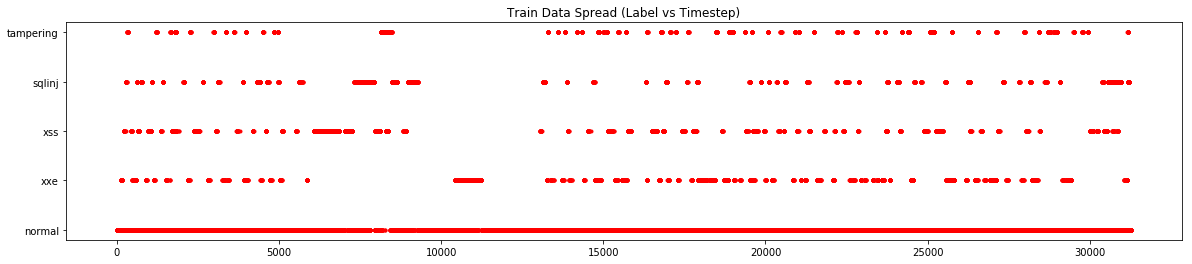

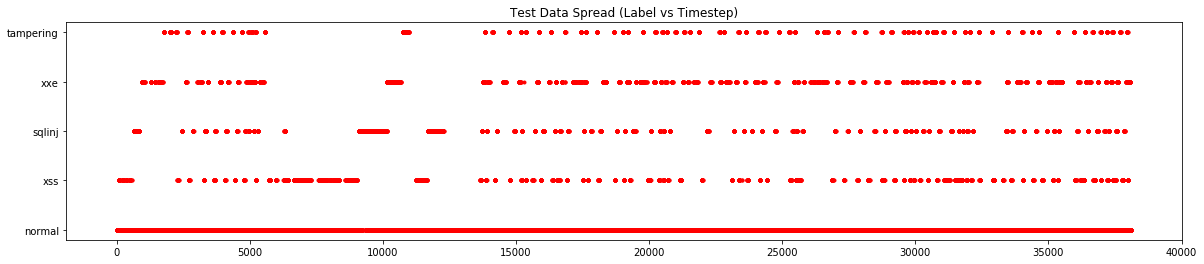

In [10]:
plt.figure(figsize=(20,4))
plt.title("Train Data Spread (Label vs Timestep)")
plt.plot(train_data['label'], 'r.')
plt.show()
print("\n")
plt.figure(figsize=(20,4))
plt.title("Test Data Spread (Label vs Timestep)")
plt.plot(test_data['label'], 'r.')
plt.show()

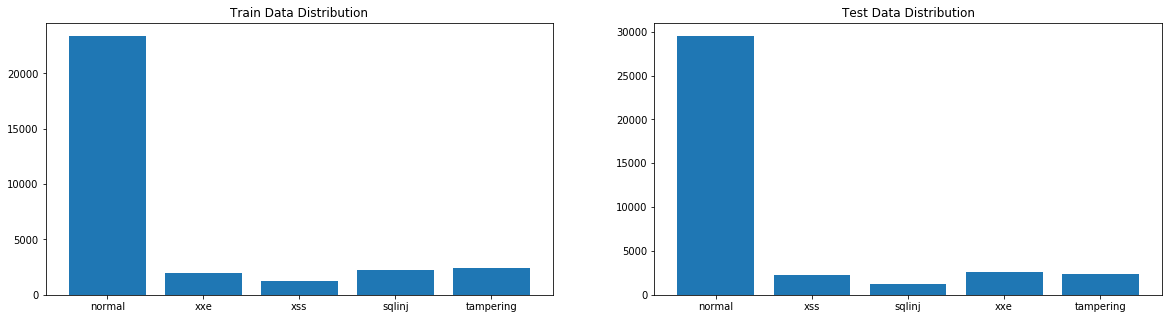

In [11]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Train Data Distribution")
plt.bar(train_data['label'].unique(),
        train_data.groupby('label').apply(lambda x: len(x)))
plt.subplot(122)
plt.title("Test Data Distribution")
plt.bar(test_data['label'].unique(),
        test_data.groupby('label').apply(lambda x: len(x)))
plt.show()

In [0]:
def method_to_index(x):
    method_dict =  {
        'GET': 0,
        'POST': 1,
        'PUT': 2,
    }
    try:
        retVal = method_dict[x]
        return retVal
    except:
        return max(method_dict.values()) + 1

In [0]:
def label_to_index(x):
    label_dict = {
        'normal': 0,
        'xss': 1,
        'tampering': 2,
        'xxe': 3,
        'sqlinj': 4
    }
    try:
        retVal = label_dict[x]
        return retVal
    except:
        return max(label_dict.values()) + 1

In [0]:
def merge_into_sequences(data):
    merged_data = []
    AVG_RECORDS_NUM_PER_SCENARIO = 3
    MIN_REC = 14
    normal_ports = [43333, 43336, 43337, 43338, 43339, 43340]
    for p in np.unique(data['port']):
        temp = []
        for idx, row in data[data['port'] == int(p)].iterrows():
            randomized_max = randint(AVG_RECORDS_NUM_PER_SCENARIO,
                                     AVG_RECORDS_NUM_PER_SCENARIO * 2)
            if row['path'] == '/' or len(temp) == 0 or \
                (int(p) in normal_ports and len(temp[-1]) >= 10 and \
                 len(temp[-1][9]) >= randomized_max):
            
                if int(p) == 43334 and len(temp) > 0 and \
                    len(temp[-1]) >= 10 and len(temp[-1][9]) < MIN_REC:
                    
                    pass
                else:
                    temp.append([])
            
            # Features: 
        
            # 1. List of tokens in all paths
            if len(temp[-1]) < 1:
                temp[-1].append([])
            tokens = re.split(r'\W+', row['path'])
            for w in tokens:
                if w != '' and not w.isnumeric():
                    temp[-1][0].append(w.lower())
                
            # 2. Total length of all paths
            if len(temp[-1]) < 2:
                temp[-1].append(0)
            temp[-1][1] += len(row['path'])
        
            # 3. Total number of punctuations, numbers,
            # and non-ascii characters in all paths
            if len(temp[-1]) < 3:
                temp[-1].append(0)
            for c in row['path']:
                if c in string.punctuation or c.isnumeric() or ord(c) < 128:
                    temp[-1][2] += 1
        
            # 4. List of tokens in all params
            if len(temp[-1]) < 4:
                temp[-1].append([])
            tokens = re.split(r'\W+', urllib.parse.unquote(row['params']))
            for w in tokens:
                if w != '' and not w.isnumeric():
                    temp[-1][3].append(w.lower())
        
            # 5. Total length of all params
            if len(temp[-1]) < 5:
                temp[-1].append(0)
            temp[-1][4] += len(row['params'])
        
            # 6. Total number of punctuations, numbers,
            # and non-ascii characters in all params
            if len(temp[-1]) < 6:
                temp[-1].append(0)
            for c in row['params']:
                if c in string.punctuation or c.isnumeric() or ord(c) < 128:
                    temp[-1][5] += 1
        
            # 7. List of tokens in all request bodies
            if len(temp[-1]) < 7:
                temp[-1].append([])
            if row['request_body'] != '':
                body_dict = json.loads(row['request_body'])
                for k in body_dict:
                    temp[-1][6].append(k.lower())
                    for word in re.split(r'\W+', str(body_dict[k])):
                        if word != '' and not word.isnumeric():
                            temp[-1][6].append(word.lower())
        
            # 8. Total length of all request bodies
            if len(temp[-1]) < 8:
                temp[-1].append(0)
            temp[-1][7] += len(row['request_body'])
        
            # 9. Total number of punctuations, numbers,
            # and non-ascii characters in all request bodies
            if len(temp[-1]) < 9:
                temp[-1].append(0)
            for c in row['request_body']:
                if c in string.punctuation or c.isnumeric() or ord(c) < 128:
                    temp[-1][8] += 1
        
            # 10. List of response codes
            if len(temp[-1]) < 10:
                temp[-1].append([])
            temp[-1][9].append(row['response_code'])
        
            # 11. List of methods
            if len(temp[-1]) < 11:
                temp[-1].append([])
            temp[-1][10].append(row['method'])
        
            # 12. Label
            if len(temp[-1]) < 12:
                temp[-1].append(row['label'])

        # print("Port:", p, ", Length:", len(temp))
        for s in temp:
            merged_data.append(s)
        
    df = pd.DataFrame(merged_data,
                      columns=['path_list', 'total_path_len',
                               'total_path_punc', 'param_list',
                               'total_param_len', 'total_param_punc',
                               'body_list', 'total_body_len',
                               'total_body_punc', 'resp_code_list',
                               'method_list', 'label'])
    return df

In [0]:
train_df = merge_into_sequences(train_data)
test_df = merge_into_sequences(test_data)

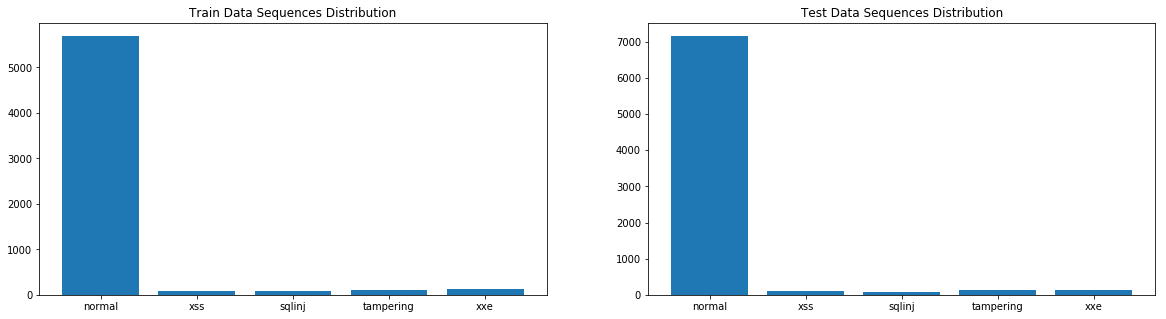

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Train Data Sequences Distribution")
plt.bar(train_df['label'].unique(),
        train_df.groupby('label').apply(lambda x: len(x)))

plt.subplot(122)
plt.title("Test Data Sequences Distribution")
plt.bar(test_df['label'].unique(),
        test_df.groupby('label').apply(lambda x: len(x)))
plt.show()

In [17]:
print("Average Sequence Length per Label (Train Dataset)")
train_df.groupby('label').apply(lambda x: x['method_list']. \
                                apply(lambda y: len(y)).mean())

Average Sequence Length per Label (Train Dataset)


label
normal        4.108535
sqlinj       21.086022
tampering    13.978022
xss          20.472222
xxe          19.821138
dtype: float64

In [0]:
MAX_PARAM_LEN = 12
MAX_BODY_LEN = 50
MAX_PATH_LEN = 65
TARGET_CLASSES_NUM = 5
METHODS_NUM = 3
CODE_NUM = 5
EXTRA_F_NUM = 6

In [0]:
seq_length = 25
dropout_rate = 0.5
learning_rate = 5e-4
total_epochs = 10
batch_size = 128
embedding_dim = 50
hidden_size = 10
swap_rate = 0.1
bias_rate = 0.1

In [0]:
train_ratio = len(train_df[train_df['label'] == 'normal']) / \
    (len(train_df[train_df['label'] != 'normal']) / (TARGET_CLASSES_NUM-1))
test_ratio = len(test_df[test_df['label'] == 'normal']) / \
    (len(test_df[test_df['label'] != 'normal']) / (TARGET_CLASSES_NUM-1))
multiplier = 2

In [0]:
def get_dataset(df, vocabs=None):
    # vocabs is a list of vocab used for no. 1-3
    vocab1 = {"<unk>": 0}
    vocab2 = {"<unk>": 0}
    vocab3 = {"<unk>": 0}
    if vocabs is not None:
        vocab1, vocab2, vocab3 = vocabs
    
    # x is a list of 6 inputs for the model
    x = []
    
    # 1. Path list
    x1 = np.zeros((len(df), MAX_PATH_LEN), dtype=int)
    
    # 2. Param list
    x2 = np.zeros((len(df), MAX_PARAM_LEN), dtype=int)
    
    # 3. Body list
    x3 = np.zeros((len(df), MAX_BODY_LEN), dtype=int)
    
    # 4. Response Code list
    x4 = np.zeros((len(df), seq_length), dtype=float)
    
    # 5. Method list
    x5 = np.zeros((len(df), seq_length, METHODS_NUM), dtype=int)
    
    # 6. Length & numbers of punc, numeric,
    # and non-ascii in all path, param, and body
    x6 = np.zeros((len(df), EXTRA_F_NUM), dtype=float)
    
    # y is the label
    y = np.zeros((len(df), TARGET_CLASSES_NUM), dtype=int)
    
    for i in range(len(df)):
        
        # Each word in the path list is transformed
        # into the index of that word in the vocab1
        for idx, w in enumerate(df['path_list'][i]):
            if vocabs is None:
                if w not in vocab1:
                    vocab1[w] = len(vocab1)
            if idx < MAX_PATH_LEN:
                x1[i, idx] = vocab1.get(w, 0)
               
        # Each word in the param list is transformed
        # into the index of that word in the vocab2
        for idx, w in enumerate(df['param_list'][i]):
            if vocabs is None:
                if w not in vocab2:
                    vocab2[w] = len(vocab2)
            if idx < MAX_PARAM_LEN:
                x2[i, idx] = vocab2.get(w, 0)
        
        # Each word in the body list is transformed
        # into the index of that word in the vocab3
        for idx, w in enumerate(df['body_list'][i]):
            if vocabs is None:
                if w not in vocab3:
                    vocab3[w] = len(vocab3)
            if idx < MAX_BODY_LEN:
                x3[i, idx] = vocab3.get(w, 0)
                
        # Get the hundreds value of each response code,
        # then scale it to be [0, 1]
        # Ex:
        #     transform response code: 302 // 100 = 3,
        #     then scale it: 3 / (5-1) = 0.75
        # The CODE_NUM is the number of possible hundreds values
        for idx, c in enumerate(df['resp_code_list'][i]):
            if idx >= seq_length:
                break
            x4[i, idx] = (c // 100) / (CODE_NUM - 1)
            
        # Each method in the method list is one-hot encoded
        for idx, m in enumerate(df['method_list'][i]):
            if idx >= seq_length:
                break
            x5[i, idx, :] = to_categorical(method_to_index(m),
                                           num_classes=METHODS_NUM)[:]
            
        # Length & numbers of punc, numeric,
        # and non-ascii in all path, param, and body
        x6[i, 0] = df['total_path_len'][i]
        x6[i, 1] = df['total_path_punc'][i]
        x6[i, 2] = df['total_param_len'][i]
        x6[i, 3] = df['total_param_punc'][i]
        x6[i, 4] = df['total_body_len'][i]
        x6[i, 5] = df['total_body_punc'][i]
        
        # The labels are one-hot encoded
        y[i, :] = to_categorical(label_to_index(df['label'][i]),
                                 num_classes=TARGET_CLASSES_NUM)[:]
    
    
    x.append(x1)
    x.append(x2)
    x.append(x3)
    x.append(x4)
    x.append(x5)
    # The sixth feature is normalized first
    # because they are real values,
    # not indexes of words in vocabs
    x.append(normalize(x6))
    
    vocabs = [vocab1, vocab2, vocab3]
    
    # Also returns the vocabs to be used
    # to encode the words in test data
    return x, y, vocabs

In [0]:
train_x, train_y, vocabs = get_dataset(train_df)
test_x, test_y, _ = get_dataset(test_df, vocabs)

In [0]:
def with_bias(features, bias_rate):
    for i in range(len(features)):
        max_b = features[i] * bias_rate
        r_b = random() * max_b
        if random() < 0.5:
            features[i] -= r_b
        else:
            features[i] += r_b
    return features
    

def swap_words(words, k):
    for _ in range(k):
        r = randint(0, len(words)-1)
        r2 = randint(0, len(words)-1)
        temp = words[r]
        words[r] = words[r2]
        words[r2] = temp
    return words
        
    
def swap_arr(arr, k):
    for _ in range(k):
        r = randint(0, len(arr)-1)
        r2 = randint(0, len(arr)-1)
        temp = deepcopy(arr[r])
        arr[r] = arr[r2]
        arr[r2] = temp
    return arr


def augment_data(train_x, train_y, repeat, repeat_normal):
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    ret_y = []
    for i in range(len(train_y)):
        rep = repeat
        if not repeat_normal:
            # Do not repeat the sequence data if it is a normal data
            if all(train_y[i] == \
                   to_categorical(0, num_classes=TARGET_CLASSES_NUM)):
                rep = 1
        for _ in range(rep):
            x1.append(swap_words(train_x[0][i],
                                 max(1, int(MAX_PATH_LEN * swap_rate))))
            x2.append(swap_words(train_x[1][i],
                                 max(1, int(MAX_PARAM_LEN * swap_rate))))
            x3.append(swap_words(train_x[2][i],
                                 max(1, int(MAX_BODY_LEN * swap_rate))))
            x4.append(swap_words(train_x[3][i],
                                 max(1, int(seq_length * swap_rate))))
            x5.append(swap_arr(train_x[4][i],
                               max(1, int(seq_length * swap_rate))))
            x6.append(with_bias(train_x[5][i], bias_rate))
            ret_y.append(train_y[i])
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    x4 = np.array(x4)
    x5 = np.array(x5)
    x6 = np.array(x6)
    
    return [x1, x2, x3, x4, x5, x6], np.array(ret_y)

In [0]:
# Attack data augmentation to make all classes similar in number
train_x, train_y = augment_data(train_x, train_y,
                                int(train_ratio), False)
aug_test_x, aug_test_y = augment_data(test_x, test_y,
                                      int(test_ratio), False)

# Multiply all classes to get more data
if multiplier > 1:
    train_x, train_y = augment_data(train_x, train_y,
                                    multiplier, True)
    aug_test_x, aug_test_y = augment_data(aug_test_x,
                                          aug_test_y,
                                          multiplier, True)

In [0]:
def shuffle_data(x, y):
    assert len(x[0]) == len(y)
    p = np.random.permutation(len(y))
    return [x[0][p], x[1][p], x[2][p], x[3][p],
            x[4][p], x[5][p]], y[p]

In [0]:
train_x, train_y = shuffle_data(train_x, train_y)
aug_test_x, aug_test_y = shuffle_data(aug_test_x, aug_test_y)

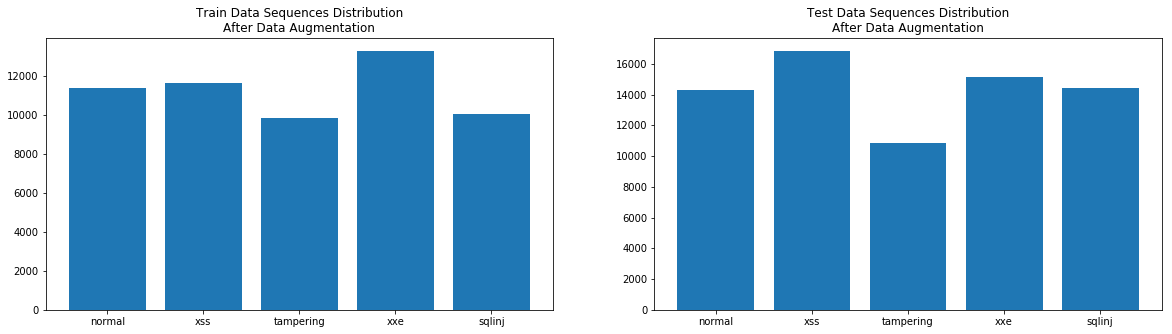

In [27]:
distribution = [0, 0, 0, 0, 0]
for l in train_y:
    distribution[l.argmax()] += 1

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Train Data Sequences Distribution\nAfter Data Augmentation")
plt.bar(['normal', 'xss', 'tampering', 'xxe', 'sqlinj'], distribution)

distribution = [0, 0, 0, 0, 0]
for l in aug_test_y:
    distribution[l.argmax()] += 1
plt.subplot(122)
plt.title("Test Data Sequences Distribution\nAfter Data Augmentation")
plt.bar(['normal', 'xss', 'tampering', 'xxe', 'sqlinj'], distribution)
plt.show()

In [28]:
print("Length of path words vocab:", len(vocabs[0]))
print("Length of param words vocab:", len(vocabs[1]))
print("Length of body words vocab:", len(vocabs[2]))

Length of path words vocab: 465
Length of param words vocab: 170
Length of body words vocab: 1493


In [29]:
for i in range(len(train_x)):
    print("Training set %d shape: %s" % (i + 1, str(train_x[i].shape)))
print("Training Label shape: %s" % str(train_y.shape))
print("\n")
for i in range(len(test_x)):
    print("Testing set %d shape: %s" % (i + 1, str(test_x[i].shape)))
print("Testing Label shape: %s" % str(test_y.shape))
print("\n")
for i in range(len(aug_test_x)):
    print("Augmented Testing set %d "
          "shape: %s" % (i + 1, str(aug_test_x[i].shape)))
print("Augmented Testing Label shape: %s" % str(aug_test_y.shape))

Training set 1 shape: (56208, 65)
Training set 2 shape: (56208, 12)
Training set 3 shape: (56208, 50)
Training set 4 shape: (56208, 25)
Training set 5 shape: (56208, 25, 3)
Training set 6 shape: (56208, 6)
Training Label shape: (56208, 5)


Testing set 1 shape: (7631, 65)
Testing set 2 shape: (7631, 12)
Testing set 3 shape: (7631, 50)
Testing set 4 shape: (7631, 25)
Testing set 5 shape: (7631, 25, 3)
Testing set 6 shape: (7631, 6)
Testing Label shape: (7631, 5)


Augmented Testing set 1 shape: (71542, 65)
Augmented Testing set 2 shape: (71542, 12)
Augmented Testing set 3 shape: (71542, 50)
Augmented Testing set 4 shape: (71542, 25)
Augmented Testing set 5 shape: (71542, 25, 3)
Augmented Testing set 6 shape: (71542, 6)
Augmented Testing Label shape: (71542, 5)


In [30]:
in_1 = Input(shape=(MAX_PATH_LEN,))
in_2 = Input(shape=(MAX_PARAM_LEN,))
in_3 = Input(shape=(MAX_BODY_LEN,))
in_4 = Input(shape=(seq_length,))
in_5 = Input(shape=(seq_length, METHODS_NUM))
in_6 = Input(shape=(EXTRA_F_NUM,))


embed_1 = Embedding(len(vocabs[0]), embedding_dim)(in_1)
dr_1a = Dropout(dropout_rate)(embed_1)
gru_out_1 = CuDNNGRU(hidden_size, kernel_regularizer=l2(1e-3))(dr_1a)
dr_1b = Dropout(dropout_rate)(gru_out_1)

embed_2 = Embedding(len(vocabs[1]), embedding_dim)(in_2)
dr_2a = Dropout(dropout_rate)(embed_2)
gru_out_2 = CuDNNGRU(hidden_size, kernel_regularizer=l2(1e-3))(dr_2a)
dr_2b = Dropout(dropout_rate)(gru_out_2)

embed_3 = Embedding(len(vocabs[2]), embedding_dim)(in_3)
dr_3a = Dropout(dropout_rate)(embed_3)
gru_out_3 = CuDNNGRU(hidden_size, kernel_regularizer=l2(1e-3))(dr_3a)
dr_3b = Dropout(dropout_rate)(gru_out_3)

dense_4 = Dense(hidden_size, activation='tanh', kernel_regularizer=l2(1e-3))(in_4)
dr_4 = Dropout(dropout_rate)(dense_4)

gru_out_5 = CuDNNGRU(hidden_size, kernel_regularizer=l2(1e-3))(in_5)
dr_5 = Dropout(dropout_rate)(gru_out_5)

dense_6 = Dense(hidden_size, activation='tanh', kernel_regularizer=l2(1e-3))(in_6)
dr_6 = Dropout(dropout_rate)(dense_6)


concated = concatenate([dr_1b, dr_2b, dr_3b, dr_4, dr_5, dr_6])

final_dense = Dense(hidden_size * 3, activation='tanh', kernel_regularizer=l2(1e-3))(concated)
final_dr = Dropout(dropout_rate)(final_dense)
final_out = Dense(TARGET_CLASSES_NUM, activation='sigmoid', kernel_regularizer=l2(1e-3))(final_dr)


model = Model(inputs=[in_1, in_2, in_3, in_4, in_5, in_6],
              outputs=[final_out])

model.summary()

optimizer = RMSprop(lr=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_x, train_y, epochs=total_epochs,
                   batch_size=batch_size, validation_split=0.2,
                   shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 65, 50)       23250       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [31]:
# testing
train_score = model.evaluate(train_x, train_y, batch_size=batch_size)
print('Training Loss: {}\n Training Accuracy: {}\n'.format(train_score[0],
                                                           train_score[1]))

test_score = model.evaluate(test_x, test_y, batch_size=batch_size)
print('Testing Loss: {}\n Testing Accuracy: {}\n'.format(test_score[0],
                                                         test_score[1]))

test_score = model.evaluate(aug_test_x, aug_test_y, batch_size=batch_size)
print('Augmented Testing Loss: {}\n Augmented Testing Accuracy: {}\n'.format(test_score[0],
                                                                             test_score[1]))

56208/56208 [==============================] - 6s 113us/step
Training Loss: 0.1137366964755627
 Training Accuracy: 0.9914602903501281

7631/7631 [==============================] - 1s 109us/step
Testing Loss: 0.1385445271281455
 Testing Accuracy: 0.9879439128771504

71542/71542 [==============================] - 8s 106us/step
Augmented Testing Loss: 0.8232808933509732
 Augmented Testing Accuracy: 0.8444829610111843



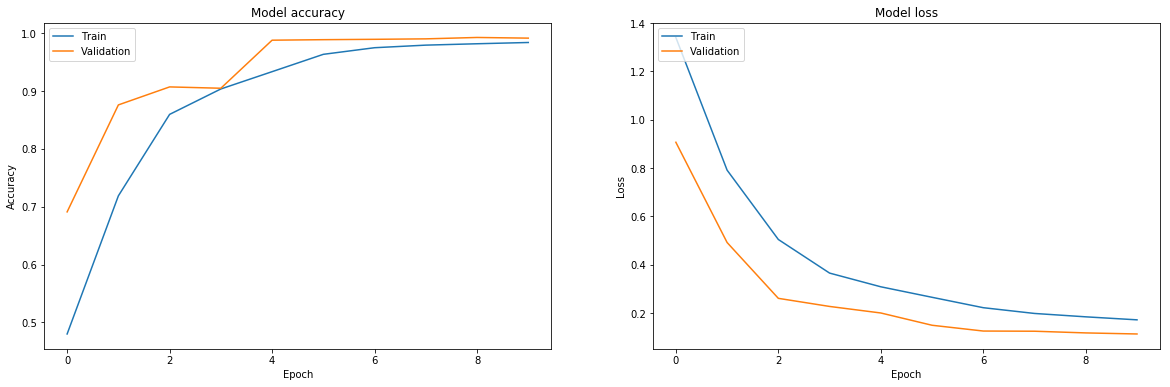

In [32]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

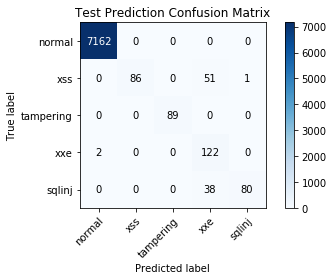

In [33]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

y_pred = model.predict(test_x, batch_size=batch_size)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(test_y, axis=-1),
                      np.argmax(y_pred, axis=-1),
                      classes=['normal', 'xss', 'tampering', 'xxe', 'sqlinj'],
                      title='Test Prediction Confusion Matrix')

In [34]:
cm = confusion_matrix(np.argmax(test_y, axis=-1),
                      np.argmax(y_pred, axis=-1))

classes=['normal', 'xss', 'tampering', 'xxe', 'sqlinj']
precs = []
recs = []

for idx, c in enumerate(classes):
    print("%s metrics:" % c)
    prec = cm[idx][idx] / sum(cm[:, idx])
    rec = cm[idx][idx] / sum(cm[idx])
    print("- Precision: %f" % prec)
    print("- Recall: %f" % rec)
    precs.append(prec)
    recs.append(rec)
    print()
    
print("Average Precision: %f" % (sum(precs) / len(classes)))
print("Average Recall: %f" % (sum(recs) / len(classes)))
print("FPR (Alarm triggered by Non-Atk): %f" % (sum(cm[0][1:]) / (sum(cm[0][:]))))

normal metrics:
- Precision: 0.999721
- Recall: 1.000000

xss metrics:
- Precision: 1.000000
- Recall: 0.623188

tampering metrics:
- Precision: 1.000000
- Recall: 1.000000

xxe metrics:
- Precision: 0.578199
- Recall: 0.983871

sqlinj metrics:
- Precision: 0.987654
- Recall: 0.677966

Average Precision: 0.913115
Average Recall: 0.857005
FPR (Alarm triggered by Non-Atk): 0.000000


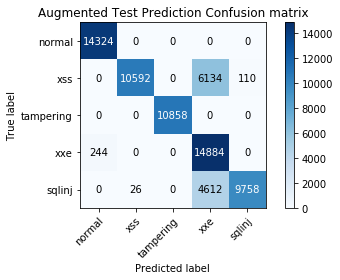

In [35]:
y_pred = model.predict(aug_test_x, batch_size=batch_size)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(aug_test_y, axis=-1),
                      np.argmax(y_pred, axis=-1),
                      classes=['normal', 'xss', 'tampering', 'xxe', 'sqlinj'],
                      title='Augmented Test Prediction Confusion matrix')

In [36]:
cm = confusion_matrix(np.argmax(aug_test_y, axis=-1),
                      np.argmax(y_pred, axis=-1))

classes=['normal', 'xss', 'tampering', 'xxe', 'sqlinj']
precs = []
recs = []

for idx, c in enumerate(classes):
    print("%s metrics:" % c)
    prec = cm[idx][idx] / sum(cm[:, idx])
    rec = cm[idx][idx] / sum(cm[idx])
    print("- Precision: %f" % prec)
    print("- Recall: %f" % rec)
    precs.append(prec)
    recs.append(rec)
    print()
    
print("Average Precision: %f" % (sum(precs) / len(classes)))
print("Average Recall: %f" % (sum(recs) / len(classes)))
print("FPR (Alarm triggered by Non-Atk): %f" % (sum(cm[0][1:]) / (sum(cm[0][:]))))

normal metrics:
- Precision: 0.983251
- Recall: 1.000000

xss metrics:
- Precision: 0.997551
- Recall: 0.629128

tampering metrics:
- Precision: 1.000000
- Recall: 1.000000

xxe metrics:
- Precision: 0.580726
- Recall: 0.983871

sqlinj metrics:
- Precision: 0.988853
- Recall: 0.677827

Average Precision: 0.910076
Average Recall: 0.858165
FPR (Alarm triggered by Non-Atk): 0.000000


In [0]:
plot_model(model, to_file='model.png', show_shapes=True)